<a href="https://colab.research.google.com/github/yingzibu/PBPK/blob/main/dis_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

def cal_f2(R:list, T:list, ver=False):
    assert len(R) == len(T)
    num_here = len(R)
    sum_diff_square = 0
    for i, j in zip(R, T):
        temp = (i - j) ** 2
        sum_diff_square += temp

    f2 = sum_diff_square / num_here + 1
    f2 = f2 ** (-0.5) * 100
    f2 = 50 * np.log10(f2) # Be careful, np.log is ln, np.log10 is used here
    if ver: print(f'F2 calculated for Reference and Test: {f2:.4f}')
    return f2

class dis_data:
    def __init__(self, df, time_points=None, col_name='Time', ref_test=['Ref', 'Test']):
        data_df = df.copy()
        if time_points == None:
            print('did not specify time points, will automatically select')
            time_points = []
            time_points_float = []
            for i in data_df.columns:
                try:
                    time_num = float(i)
                    time_points.append(i)
                    time_points_float.append(time_num)
                except: pass
        print('selected time points: ', time_points)
        self.time_points = time_points
        self.time_points_float = time_points_float
        ref_df = data_df[data_df[col_name]==ref_test[0]]
        test_df = data_df[data_df[col_name]==ref_test[1]]

        self.ref_df = ref_df[self.time_points].reset_index(drop=True)
        self.test_df = test_df[self.time_points].reset_index(drop=True)
        self.ref_mean = list(self.ref_df.mean(axis=0))
        self.test_mean = list(self.test_df.mean(axis=0))

        # when they calculate standard deviation, they use ddof=1,
        # divided by N-1 instead of N
        # calculate standard deviation for ref_df and test_df
        self.ref_sd = list(self.ref_df.std(ddof=1))
        self.test_sd = list(self.test_df.std(ddof=1))

        # calculate cv for ref and test data, cv = sd / mean at each time point
        self.ref_cv = [i/j for i, j in zip(self.ref_sd, self.ref_mean)]
        self.test_cv = [i/j for i, j in zip(self.test_sd, self.test_mean)]

        dict_here = {}
        dict_here['time_point'] = self.time_points
        dict_here['ref_mean']  = self.ref_mean
        dict_here['test_mean'] = self.test_mean
        dict_here['ref_cv']  = self.ref_cv
        dict_here['test_cv'] = self.test_cv
        self.stats = pd.DataFrame.from_dict(dict_here)
        self.idx_list = [i for i in range(len(self.time_points))]
        self.idx_list_rule_85 = []


    def view_data(self):
        print('*'*50)
        print(' reference data extracted:\n', self.ref_df)
        print('\n test data extracted:\n', self.test_df)
        print('\n mean and cv calculated:\n', self.stats)
        print('*'*50)

    def plot_data(self, xlabel='time in minutes', ylabel='% dissolved',
                  title='Mean distribution of the test and reference'):
        x_axis = self.time_points_float
        test_axis = self.test_mean
        ref_axis = self.ref_mean
        plt.plot(x_axis, test_axis, label='test batch')
        plt.plot(x_axis, ref_axis, label='ref batch')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()
        plt.close()

    def apply_85_rule(self, rule_85=True):
        idx_list = []
        if rule_85 == True: # will evaluate 85% rule
            print('---> Include 1 time point of average dissolution >85% only')
            first_85_appended = False
            for idx, (i, r, t) in enumerate(zip(self.time_points, self.ref_mean, self.test_mean)):
                if r > 85 and t > 85:
                    print(f'at time {i}, both ref mean {r:.3f} and test mean {t:.3f} > 85%', end=", ")
                    if first_85_appended == False:
                        idx_list.append(idx) # will include one time point exceeding 85%,
                        print(f'preserve time {i}')
                        first_85_appended = True
                    else: print(f'delete time {i}')
                else: idx_list.append(idx)
        else:
            print('Did not apply 85% rule, will calculate on all data')
            idx_list = [i for i in range(len(self.time_points))]

        self.idx_list_rule_85 = idx_list
        return idx_list

    def cal_f2(self, rule_85=True, ver=True):
        """
        Use of the f2 metric is allowed provided that following constraints are met:
         -    >= 3 time-points
         -    85% rule (<= 1 time point should be included with average dissolution >85%)
         -    CV <= 20% for 1st point, <=10% for other points
        """
        print('\n', '*'*40, 'F2 calculation', '*'*40)
        print('Apply 85% rule? : ', rule_85)
        if rule_85:
            if len(self.idx_list_rule_85) == 0:
                idx_list = self.apply_85_rule(rule_85=rule_85)
            else: idx_list = self.idx_list_rule_85
        else: idx_list = self.idx_list

        time_here = list(np.take(self.time_points, idx_list))

        print('\nEvaluate whether f2 is suitable :')

        if len(time_here) < 3:
            print('* WARNING: time points < 3, f2 may not be suitable')
        else:
            print(f'* Satisfy criteria for f2: {len(time_here)} time points, larger than 3')

        # evaluate CV<0.2 for first time point, CV < 0.1 for other time points rule
        test_cv_here = list(np.take(self.test_cv, idx_list))
        ref_cv_here  = list(np.take(self.ref_cv,  idx_list))

        cv_cond = True
        for idx, (i, t, r) in enumerate(zip(time_here, test_cv_here, ref_cv_here)):
            if idx == 0: # check whether CV <20%
                if t > 0.2 or r > 0.2:
                    print('CV at first time point exceeds 20%, f2 may not be suitable')
                    cv_cond = False
            else:
                if t > 0.1 or r > 0.1:
                    print(f'At time {i}, CV exceeds 10%, f2 may not be suitable')
                    cv_cond = False
        if cv_cond: print('* Satisfy CV criteria for f2 calculation')
        ref_mean_here =  list(np.take(self.ref_mean, idx_list))
        test_mean_here = list(np.take(self.test_mean, idx_list))
        print()
        return cal_f2(ref_mean_here, test_mean_here, ver=ver)

    def cal_MSD(self, rule_85=False, tolerance_list=[10,11,13,15]):
        print('\n', '*'*40, 'MSD calculation', '*'*40)
        print('Apply 85% rule? : ', rule_85)
        if rule_85:
            if len(self.idx_list_rule_85) == 0:
                idx_list = self.apply_85_rule(rule_85=rule_85)
            else: idx_list = self.idx_list_rule_85

        else: idx_list = self.idx_list

        time_points = list(np.take(self.time_points, idx_list))
        ref_df = self.ref_df[time_points]
        test_df = self.test_df[time_points]
        P = len(time_points)
        n = len(ref_df)

        try: assert n == len(test_df)
        except:
            print(f'ref units {n} are different from test units {len(test_df)}')
            print('Check data before cal MSD'); return

        S1 = ref_df.cov()
        S2 = test_df.cov()
        S_pooled = (S1 + S2) / 2

        x2_x1 = [i-j for i, j in zip(self.test_mean, self.ref_mean)]
        x2_x1 = list(np.take(x2_x1, idx_list))
        a = np.array(x2_x1).reshape(len(time_points), 1)
        K = n**2/(2*n)* (2*n - P - 1) / ((2*n - 2) * P)
        Fcrit = scipy.stats.f.ppf(q=1-.1, dfn=P, dfd=2*n-P-1)
        spinv = np.linalg.inv(S_pooled.loc[time_points, time_points])
        D_M = np.sqrt(a.T @ spinv @ a)[0][0]
        print('Mahalanobis distance (T & R):', D_M)

        bound1 = a @ (1 + np.sqrt(Fcrit/(K * a.T @ spinv @ a)))
        bound2 = a @ (1 - np.sqrt(Fcrit/(K * a.T @ spinv @ a)))
        # 90% CI of Mahalanobis distance:
        DM_1 = np.sqrt(bound1.T @ spinv @ bound1)[0][0]
        DM_2 = np.sqrt(bound2.T @ spinv @ bound2)[0][0]
        DM_upper = max(DM_1, DM_2)
        DM_lower = min(DM_1, DM_2)

        print('lower bound of DM:', DM_lower)
        print('upper bound of DM:', DM_upper)
        print('DM_upper | tolerance limit | conclusion')
        for tolerance in tolerance_list:

            D_g = np.array([tolerance] * len(time_points)).reshape(len(time_points), 1)
            RD = np.sqrt(D_g.T @ spinv @ D_g)[0][0]

            # print(f'Maximum Mahalanobis distance at {tolerance}% tolerance: {RD:.3f}')

            if DM_upper <= RD:
                print(f'{DM_upper:.3f} \t <=  {RD:.3f}[{tolerance}%]     Similar')
            else:
                print(f'{DM_upper:.3f} \t >   {RD:.3f} [{tolerance}%]    Dissimilar')

In [2]:
! git clone https://github.com/yingzibu/PBPK.git --quiet

In [3]:
file_name = 'PBPK/paper_table_1.xlsx'
data_df = pd.read_excel(file_name)
data_df

,Batch,Tablet,5,10,15,20,30,60,90,120
0,REF,1,42.06,59.91,65.58,71.81,77.77,85.67,93.14,94.23
1,REF,2,44.16,60.18,67.17,70.82,76.11,83.27,88.01,89.59
2,REF,3,45.63,55.77,65.56,70.50,76.92,83.91,86.83,90.12
3,REF,4,48.52,60.39,66.51,73.06,78.54,84.99,88.00,93.43
4,REF,5,50.49,61.82,69.06,72.85,78.99,86.86,89.70,90.79
5,REF,6,49.77,62.73,69.77,72.88,80.18,84.20,88.88,90.47
6,TEST,1,19.99,36.70,47.77,55.08,65.69,81.37,92.39,97.10
7,TEST,2,22.08,39.29,49.46,56.79,67.22,82.42,89.93,95.62
8,TEST,3,21.93,38.54,47.76,55.14,65.25,83.49,90.19,95.62
9,TEST,4,22.44,38.46,49.72,58.67,69.21,84.93,94.12,95.51


In [4]:
data_here = dis_data(data_df, col_name='Batch', ref_test=['REF', 'TEST'])
data_here.view_data()

did not specify time points, will automatically select
selected time points:  [5, 10, 15, 20, 30, 60, 90, 120]
**************************************************
 reference data extracted:
        5     10     15     20     30     60     90    120
0  42.06  59.91  65.58  71.81  77.77  85.67  93.14  94.23
1  44.16  60.18  67.17  70.82  76.11  83.27  88.01  89.59
2  45.63  55.77  65.56  70.50  76.92  83.91  86.83  90.12
3  48.52  60.39  66.51  73.06  78.54  84.99  88.00  93.43
4  50.49  61.82  69.06  72.85  78.99  86.86  89.70  90.79
5  49.77  62.73  69.77  72.88  80.18  84.20  88.88  90.47

 test data extracted:
        5     10     15     20     30     60     90    120
0  19.99  36.70  47.77  55.08  65.69  81.37  92.39  97.10
1  22.08  39.29  49.46  56.79  67.22  82.42  89.93  95.62
2  21.93  38.54  47.76  55.14  65.25  83.49  90.19  95.62
3  22.44  38.46  49.72  58.67  69.21  84.93  94.12  95.51
4  25.67  42.35  52.68  59.71  71.51  86.61  93.80  96.70
5  26.37  41.34  51.01  57.75  6

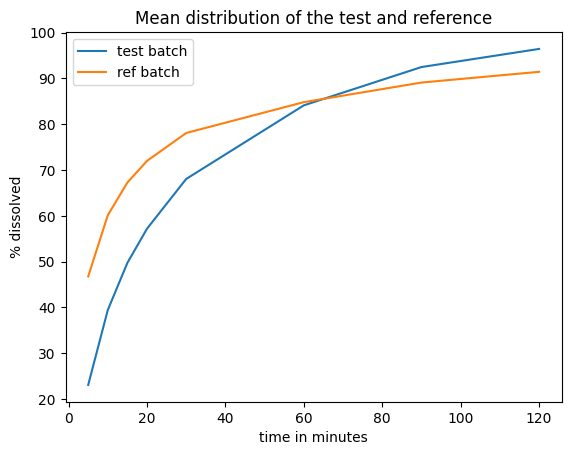

In [5]:
data_here.plot_data()

In [6]:
rule_85 = False # Do not apply 85% rule, calculate on all data
data_here.cal_f2(rule_85=rule_85)
data_here.cal_MSD(rule_85=rule_85)


 **************************************** F2 calculation ****************************************
Apply 85% rule? :  False

Evaluate whether f2 is suitable :
* Satisfy criteria for f2: 8 time points, larger than 3
* Satisfy CV criteria for f2 calculation

F2 calculated for Reference and Test: 42.0650

 **************************************** MSD calculation ****************************************
Apply 85% rule? :  False
Mahalanobis distance (T & R): 26.07918991319184
lower bound of DM: 19.246802283333956
upper bound of DM: 32.91157754304976
DM_upper | tolerance limit | conclusion
32.912 	 >   21.572 [10%]    Dissimilar
32.912 	 >   23.729 [11%]    Dissimilar
32.912 	 >   28.043 [13%]    Dissimilar
32.912 	 >   32.357 [15%]    Dissimilar


In [7]:
rule_85 = True # Apply 85% rule
data_here.cal_f2(rule_85=rule_85)
data_here.cal_MSD(rule_85=rule_85)


 **************************************** F2 calculation ****************************************
Apply 85% rule? :  True
---> Include 1 time point of average dissolution >85% only
at time 90, both ref mean 89.093 and test mean 92.480 > 85%, preserve time 90
at time 120, both ref mean 91.438 and test mean 96.437 > 85%, delete time 120

Evaluate whether f2 is suitable :
* Satisfy criteria for f2: 7 time points, larger than 3
* Satisfy CV criteria for f2 calculation

F2 calculated for Reference and Test: 40.7864

 **************************************** MSD calculation ****************************************
Apply 85% rule? :  True
Mahalanobis distance (T & R): 25.13264678994685
lower bound of DM: 20.314904951477327
upper bound of DM: 29.950388628416384
DM_upper | tolerance limit | conclusion
29.950 	 >   10.305 [10%]    Dissimilar
29.950 	 >   11.335 [11%]    Dissimilar
29.950 	 >   13.396 [13%]    Dissimilar
29.950 	 >   15.457 [15%]    Dissimilar
